In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,GlobalAveragePooling2D

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator as Imgen

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install split-folders --quiet

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/vehicle detection system/data",output='splitted',ratio=(0.8,0.1,0.1))

Copying files: 860 files [00:11, 75.41 files/s] 


In [ ]:
train_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/train",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

val_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/val",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

test_ds = Imgen(rescale=1./255).flow_from_directory(
    "./splitted/test",
    seed = 1,
    target_size = (150,150),
    batch_size = 32
)

Found 688 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [ ]:
train_ds.class_indices

{'non-vehicles': 0, 'vehicles': 1}

In [ ]:
x_train,y_train = next(train_ds)
print(x_train.shape,y_train.shape)

(32, 150, 150, 3) (32, 2)


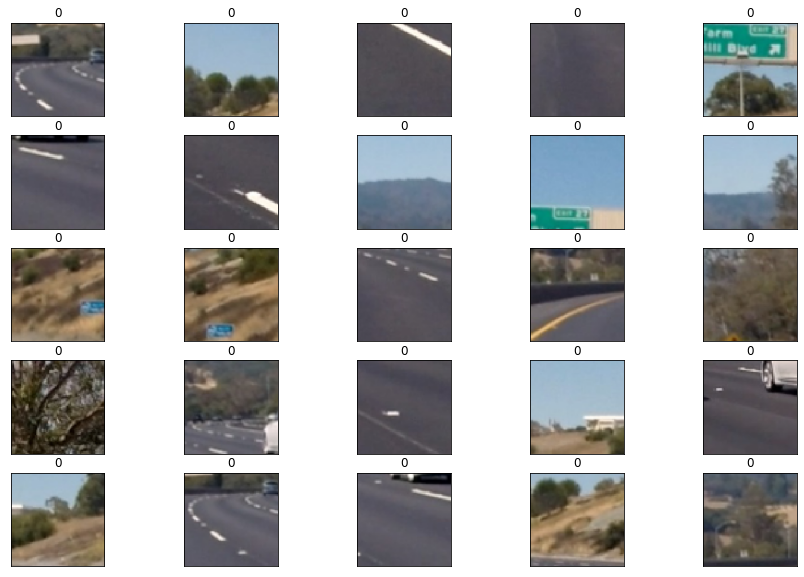

In [ ]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.title(np.argmax(y_train[i]))


In [ ]:
from keras.applications.xception import Xception 

In [ ]:
base_model = Xception(weights='imagenet',
                     input_shape=(150,150,3),
                      include_top=False
                     )
base_model.trainable = False

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model = keras.models.Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(2,activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd',loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [ ]:
hist = model.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 callbacks=[callback]
                )

Epoch 1/10
22/22 [==============================] - 63s 3s/step - loss: 0.5832 - accuracy: 0.9346 - val_loss: 0.4974 - val_accuracy: 1.0000
Epoch 2/10
22/22 [==============================] - 57s 3s/step - loss: 0.4595 - accuracy: 1.0000 - val_loss: 0.4432 - val_accuracy: 1.0000
Epoch 3/10
22/22 [==============================] - 58s 3s/step - loss: 0.4232 - accuracy: 1.0000 - val_loss: 0.4221 - val_accuracy: 1.0000
Epoch 4/10
22/22 [==============================] - 57s 3s/step - loss: 0.4069 - accuracy: 1.0000 - val_loss: 0.4105 - val_accuracy: 1.0000


In [ ]:
#test
model.evaluate(test_ds)

3/3 [==============================] - 6s 2s/step - loss: 0.3898 - accuracy: 1.0000


[0.389828085899353, 1.0]

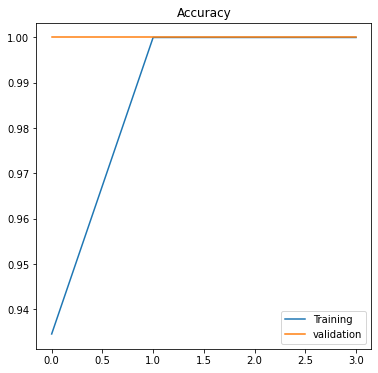

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()
plt.show()

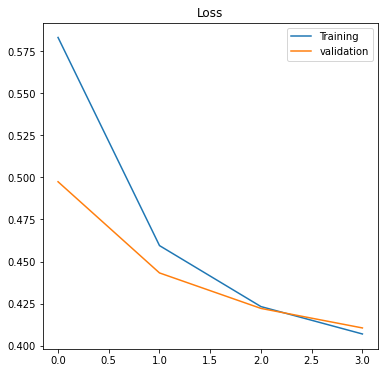

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
x_test,y_test = next(test_ds)

In [ ]:
pred_test = model.predict(x_test)
pred_test = [np.argmax(i) for i in pred_test]

In [ ]:
test_dict = test_ds.class_indices
li_pred = list(test_dict.keys())
li_pred

['non-vehicles', 'vehicles']

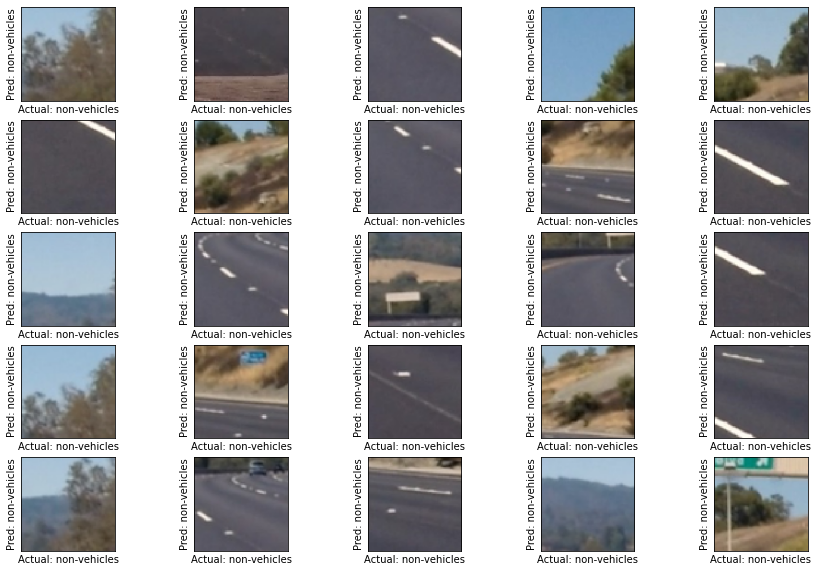

In [ ]:
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i])
    plt.xlabel("Actual: {}".format(li_pred[np.argmax(y_test[i])]))
    plt.ylabel("Pred: {}".format(li_pred[pred_test[i]]))

In [ ]:
import os
os.chdir("/content/drive/")
!ls

MyDrive


In [ ]:
plt.imshow(Image.open("/content/drive/MyDrive/vehicle detection system/data/non-vehicles/1.png"))

FileNotFoundError: ignored

In [ ]:
def predict_image(dir):
    img = image.load_img(dir,target_size=(150,150))
    img  = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    pred_img = model.predict(img)
    
    return li_pred[np.argmax(pred_img)]

In [ ]:
print(predict_image('/content/drive/MyDrive/vehicle detection system/data/non-vehicles/1.png'))